# Intro Task, Object Localization 

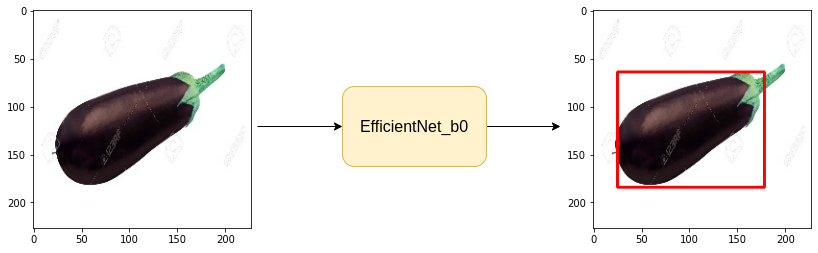

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-vvygrgcm
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-vvygrgcm
  Resolved https://github.com/albumentations-team/albumentations to commit cb372736a0b7da362e5c2e23f3cce4304ddac402
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125638 sha256=6764290668ec77f6741d6ff22062a9c0fcb726f8e50b8a535176428026ef5d6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-70pns_cb/wheels/f3/4a/7f/67b055656bec4d4aaa8963cfc93678f6f2906b2d72054a1268
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
L

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 1.82 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE = "/content/object-localization-dataset/train.csv"
DATA_DIR = "/content/object-localization-dataset/"
DEVICE = "cuda"

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = "efficientnet_b0" # 'resnet50' or 'resnet34d'
NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

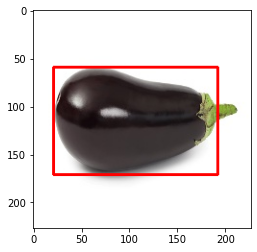

In [7]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# To plot Bounding Box (next 3 rows of code)
pt1 = (row.xmin,row.ymin)
pt2 = (row.xmax,row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2,(255,0,0),2) 

plt.imshow(img)

In [8]:
train_df,valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params = A.BboxParams(format = "pascal_voc", label_fields = ["class_labels"]))



valid_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
],bbox_params = A.BboxParams(format = "pascal_voc", label_fields = ["class_labels"]))

# Create Custom Dataset

In [11]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self,df,augmentations = None):
    self.df = df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox = [[xmin,ymin,xmax,ymax]]
    img_path = DATA_DIR +row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if self.augmentations:
      data = self.augmentations(image = img,bboxes = bbox,class_labels = [None])
      img = data["image"]
      bbox = data["bboxes"][0]
    img = torch.from_numpy(img).permute(2,0,1)/255.0 # (h,w,c) --> (c,h,w)
    bbox = torch.Tensor(bbox)
    return img, bbox

In [12]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [13]:
print(f"Total example in the trainset : {len(trainset)}")
print(f"Total example in the validset : {len(validset)}")

Total example in the trainset : 148
Total example in the validset : 38


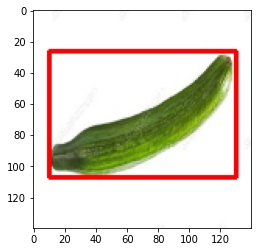

In [14]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset,batch_size = BATCH_SIZE, shuffle = False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images, bboxes in trainloader:
  break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn 
import timm

In [19]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel,self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)
  def forward(self,images,gt_bboxes = None):
    bboxes = self.backbone(images) 
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes,gt_bboxes)
      return bboxes, loss
    return bboxes

In [20]:
model = ObjLocModel()
model.to(DEVICE); # Remove semicolan to see the output

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


# Create Train and Eval Function

In [21]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() # Dropout in ON Mode
  for data in tqdm(dataloader):
    images,gt_bboxes = data
    images,gt_bboxes = images.to(DEVICE),gt_bboxes.to(DEVICE)
    bboxes, loss = model(images,gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(dataloader)

In [22]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval() # Dropout in OFF mode
  with torch.no_grad():
    for data in tqdm(dataloader):
      images,gt_bboxes = data
      images,gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
      bboxes, loss = model(images, gt_bboxes)

      total_loss +=loss.item()
    return total_loss / len(dataloader)

#Training Loop

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [24]:
best_valid_loss = np.inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("WEIGHTS ARE SAVED")
    best_valid_loss = valid_loss
  print(f"EPOCH : {i+1} train loss : {train_loss} valid_loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 1 train loss : 5453.270581054688 valid_loss : 5286.022623697917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 2 train loss : 2164.5824340820313 valid_loss : 3986.07861328125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 3 train loss : 1271.9037719726562 valid_loss : 395.5922139485677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 4 train loss : 875.649462890625 valid_loss : 214.4134063720703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 5 train loss : 622.1741943359375 valid_loss : 233.3872324625651


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 6 train loss : 492.55959167480466 valid_loss : 238.09321085611978


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 7 train loss : 360.0463897705078 valid_loss : 309.6116231282552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 8 train loss : 253.41661682128907 valid_loss : 219.43043009440103


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 9 train loss : 228.66988525390624 valid_loss : 262.96241760253906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 10 train loss : 199.12586822509766 valid_loss : 109.80825551350911


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 11 train loss : 149.68571701049805 valid_loss : 165.27154541015625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 12 train loss : 142.58397674560547 valid_loss : 95.61450703938802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 13 train loss : 101.31609916687012 valid_loss : 119.90621439615886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 14 train loss : 98.13254356384277 valid_loss : 102.65132904052734


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 15 train loss : 86.36042098999023 valid_loss : 105.55895233154297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 16 train loss : 88.62521362304688 valid_loss : 103.6342061360677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 17 train loss : 75.95241088867188 valid_loss : 107.87434895833333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 18 train loss : 86.58283576965331 valid_loss : 94.86511484781902


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 19 train loss : 74.12426624298095 valid_loss : 108.02300771077473


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 20 train loss : 60.616051864624026 valid_loss : 83.17989603678386


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 21 train loss : 57.19428825378418 valid_loss : 72.39078521728516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 22 train loss : 63.46140041351318 valid_loss : 58.95533752441406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 23 train loss : 55.50822010040283 valid_loss : 76.41618728637695


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 24 train loss : 55.16098899841309 valid_loss : 79.72180048624675


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 25 train loss : 46.47897853851318 valid_loss : 81.05050150553386


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 26 train loss : 53.05489883422852 valid_loss : 96.37386067708333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 27 train loss : 45.799518775939944 valid_loss : 56.015740712483726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 28 train loss : 37.74583683013916 valid_loss : 84.12083180745442


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 29 train loss : 47.6654354095459 valid_loss : 64.59590657552083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 30 train loss : 39.2947811126709 valid_loss : 77.73415501912434


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 31 train loss : 52.8051399230957 valid_loss : 69.97387440999348


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 32 train loss : 32.646107292175294 valid_loss : 62.920875549316406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 33 train loss : 39.87673377990723 valid_loss : 49.14636739095052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 34 train loss : 39.25522003173828 valid_loss : 59.64489428202311


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 35 train loss : 36.431715965270996 valid_loss : 65.64238739013672


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 36 train loss : 39.790951347351076 valid_loss : 72.71407063802083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 37 train loss : 44.114806175231934 valid_loss : 55.793312072753906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 38 train loss : 53.622483253479004 valid_loss : 69.13180669148763


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 39 train loss : 44.943137550354 valid_loss : 55.077162424723305


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 40 train loss : 65.41516151428223 valid_loss : 80.48944854736328


#Inference

In [25]:
import cv2
import numpy
import torch 

import matplotlib.pyplot as plt 

def compare_plots(image, gt_bbox, out_bbox):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)

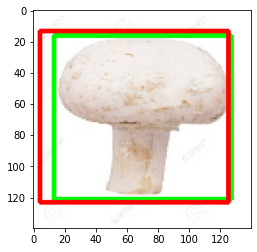

In [26]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
  image, gt_bbox = validset[1] #(c,h,w)
  image = image.unsqueeze(0).to(DEVICE) #(bs,c,h,w)
  out_bbox = model(image)
  compare_plots(image, gt_bbox, out_bbox)